In [2]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN
import re
warnings.filterwarnings('ignore')

In [2]:
# import skin cancer patients dataset
skin_cancer = pd.read_csv('full-dataset.csv', delimiter = ',')
# remove MUTATION_CDS which are unkown
skin_cancer = skin_cancer[skin_cancer['Mutation CDS'] != 'c.?']
# remove MUTATION_AA which are unkown
skin_cancer = skin_cancer[skin_cancer['Mutation AA'] != 'p.?']
# dataset with selected genes 
skin_cancer = skin_cancer[skin_cancer['Gene name'].isin(['BRAF','MUC16','NRAS','LRP1B'])]
skin_cancer = skin_cancer.reset_index(drop=True)
# Is Melanoma ?
# set traget label to Is Melanoma ? based on primary histology
skin_cancer['Is Melanoma ?'] = np.where(skin_cancer['Primary histology'] == 'malignant_melanoma', 'Yes', 'No')
# filter Substitution - Missense, Substitution - Nonsese 
skin_cancer = skin_cancer[(skin_cancer['Mutation Description'] == 'Substitution - Missense') | (skin_cancer['Mutation Description'] == 'Substitution - Nonsense')]
skin_cancer.reset_index(drop=True)
# select columns    
skin_cancer = skin_cancer[['Gene name', 'Age' ,'FATHMM score','Tumour origin','Tier', 'Mutation CDS','Is Melanoma ?']]
df = skin_cancer.copy()
df.columns = ['GENE_NAME','AGE','FATHMM_SCORE', 'TUMOUR_ORIGIN', 'TIER','MUTATION_CDS','IS MEALANOMA ?']
df.head()

,GENE_NAME,AGE,FATHMM_SCORE,TUMOUR_ORIGIN,TIER,MUTATION_CDS,IS MEALANOMA ?
0,NRAS,68.0,0.99541,NS,1,c.461A>G,No
1,BRAF,NaN,0.98542,primary,1,c.1799T>A,No
2,BRAF,58.0,0.98542,NS,1,c.1799T>A,No
3,MUC16,51.0,0.03009,primary,2,c.16061C>A,No
4,NRAS,NaN,0.92782,primary,1,c.34G>C,No


In [3]:
df.shape

(34661, 7)

In [4]:
# define codon table
protein = {"TTT" : "F", "CTT" : "L", "ATT" : "I", "GTT" : "V",
           "TTC" : "F", "CTC" : "L", "ATC" : "I", "GTC" : "V",
           "TTA" : "L", "CTA" : "L", "ATA" : "I", "GTA" : "V",
           "TTG" : "L", "CTG" : "L", "ATG" : "M", "GTG" : "V",
           "TCT" : "S", "CCT" : "P", "ACT" : "T", "GCT" : "A",
           "TCC" : "S", "CCC" : "P", "ACC" : "T", "GCC" : "A",
           "TCA" : "S", "CCA" : "P", "ACA" : "T", "GCA" : "A",
           "TCG" : "S", "CCG" : "P", "ACG" : "T", "GCG" : "A",
           "TAT" : "Y", "CAT" : "H", "AAT" : "N", "GAT" : "D",
           "TAC" : "Y", "CAC" : "H", "AAC" : "N", "GAC" : "D",
           "TAA" : "STOP", "CAA" : "Q", "AAA" : "K", "GAA" : "E",
           "TAG" : "STOP", "CAG" : "Q", "AAG" : "K", "GAG" : "E",
           "TGT" : "C", "CGT" : "R", "AGT" : "S", "GGT" : "G",
           "TGC" : "C", "CGC" : "R", "AGC" : "S", "GGC" : "G",
           "TGA" : "STOP", "CGA" : "R", "AGA" : "R", "GGA" : "G",
           "TGG" : "W", "CGG" : "R", "AGG" : "R", "GGG" : "G" 
           }

def dna_to_protein(dna):
    '''
        This function takes dna sequence as string 
        and convert into amino acid sequence 
    '''
    
    protein_sequence = ""

    # Generate protein sequence
    for i in range(0, len(dna)-(3+len(dna)%3), 3):
        if protein[dna[i:i+3]] == "STOP" :
            break
        protein_sequence += protein[dna[i:i+3]]
        
    return protein_sequence

In [5]:
import requests
from string import Template

BASE_URL = 'https://cancer.sanger.ac.uk/cosmic/'
SEQUENCE_URL = Template('sequence?ln=$gene&type=$_type')

'''
    @params 
        gene - Gene Type
        _type - Sequnce Type (DNA or Protein)
    
    @returns 
        sequence (String)
'''
def get_sequence(gene='BRAF', _type='cdna'):
    URL = BASE_URL + SEQUENCE_URL.substitute(gene=gene,_type=_type)
    print(f'GET -----> {URL}')
    request = requests.get(url = URL)
    sequence = request.text
    sequence = sequence.split('\n')
    sequence = ''.join(sequence[1:len(sequence)-1])
    if _type.lower() == 'protein':
        sequence = sequence[:len(sequence)-1]
    return sequence

In [6]:
# get genes DNA sequence from COSMIC API
GENE_NAMES = ['BRAF','MUC16','NRAS','LRP1B']
GENES = dict()

for gene in GENE_NAMES:
    GENES[gene] = get_sequence(gene)

GET -----> https://cancer.sanger.ac.uk/cosmic/sequence?ln=BRAF&type=cdna
GET -----> https://cancer.sanger.ac.uk/cosmic/sequence?ln=MUC16&type=cdna
GET -----> https://cancer.sanger.ac.uk/cosmic/sequence?ln=NRAS&type=cdna
GET -----> https://cancer.sanger.ac.uk/cosmic/sequence?ln=LRP1B&type=cdna


In [7]:
## regex to validate dna substitution 

regex = "^c\.[1-9]\d*[ACGT]>[ACGT]$"

In [8]:
'''
  @params 
    gene - gene name
    substitution - dna single point substitution

  @returns 
    mutated amino acid sequence (protein primary structure)
'''
def get_mutated_amino_acid_seq(gene,substitution):
    if gene in GENES.keys():
        if re.search(regex,substitution):
            numbers = list(map(int,re.findall(r'\d+', substitution)))
            if len(numbers) == 1:
                temp = list(GENES[gene])
                temp[numbers[0]-1] = substitution.split('>')[1]
                return dna_to_protein(''.join(temp)) 
            raise Exception("Something went wrong")
        # print(substitution)
        raise Exception("substitution in invalid format. Correct format is c.(num)(char)>(char)")
    raise Exception(f"Unknown gene... Genes : %s", ','.join(list(GENES.keys())))  


In [9]:
mutated_sequences = list()

array = list()

for index, row in df.iterrows():
    try :
        seq = get_mutated_amino_acid_seq(row['GENE_NAME'],row['MUTATION_CDS'])
        array.append({'GENE_NAME' : row['GENE_NAME'],  'AGE' : row['AGE'] , 'TUMOUR_ORIGIN' : row['TUMOUR_ORIGIN'] , 'TIER' : row['TIER'], 
                  'PROTEIN_PRIMARY_STRUCTURE' : seq, 'IS MEALANOMA ?' : row['IS MEALANOMA ?']})
    except:
        continue

df2 = pd.DataFrame(array)
df2.head()

,GENE_NAME,AGE,TUMOUR_ORIGIN,TIER,PROTEIN_PRIMARY_STRUCTURE,IS MEALANOMA ?
0,NRAS,68.0,NS,1,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,No
1,BRAF,NaN,primary,1,MAALSGGGGGGAEPGQALFNGDMEPEAGAGAGAAASSAADPAIPEE...,No
2,BRAF,58.0,NS,1,MAALSGGGGGGAEPGQALFNGDMEPEAGAGAGAAASSAADPAIPEE...,No
3,MUC16,51.0,primary,2,MLKPSGLPGSSSPTRSLMTGSRSTKATPEMDSGLTGATLSPKTSTG...,No
4,NRAS,NaN,primary,1,MTEYKLVVVGARGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,No


In [10]:
df2.shape

(33906, 6)

In [11]:
GENE_NAME_codes = dict()
index = 0
for topic in list(df2['GENE_NAME'].unique()):
    GENE_NAME_codes[topic] = index
    index += 1

GENE_NAME_codes

{'NRAS': 0, 'BRAF': 1, 'MUC16': 2, 'LRP1B': 3}

In [12]:
IS_MELANOMA_codes = dict()
index = 0
for topic in list(df2['IS MEALANOMA ?'].unique()):
    IS_MELANOMA_codes[topic] = index
    index += 1

IS_MELANOMA_codes

{'No': 0, 'Yes': 1}

In [13]:
Tumour_origin_codes = dict()
index = 0
for topic in list(df2['TUMOUR_ORIGIN'].unique()):
    Tumour_origin_codes[topic] = index
    index += 1

Tumour_origin_codes

{'NS': 0,
 'primary': 1,
 'metastasis': 2,
 'secondary': 3,
 'recurrent': 4,
 'hyperplasia adjacent to primary tumour': 5}

In [14]:
df3 = df2.copy()
df3.replace({'GENE_NAME' : GENE_NAME_codes,  'IS MEALANOMA ?' : IS_MELANOMA_codes, 'TUMOUR_ORIGIN' : Tumour_origin_codes }, inplace=True)
df3.head()

,GENE_NAME,AGE,TUMOUR_ORIGIN,TIER,PROTEIN_PRIMARY_STRUCTURE,IS MEALANOMA ?
0,0,68.0,0,1,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,0
1,1,NaN,1,1,MAALSGGGGGGAEPGQALFNGDMEPEAGAGAGAAASSAADPAIPEE...,0
2,1,58.0,0,1,MAALSGGGGGGAEPGQALFNGDMEPEAGAGAGAAASSAADPAIPEE...,0
3,2,51.0,1,2,MLKPSGLPGSSSPTRSLMTGSRSTKATPEMDSGLTGATLSPKTSTG...,0
4,0,NaN,1,1,MTEYKLVVVGARGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,0


In [15]:
# replace NaN values in age by zero
df3['AGE'].fillna(value = 0, inplace = True)

<AxesSubplot:title={'center':'Melanoma Yes/No'}>

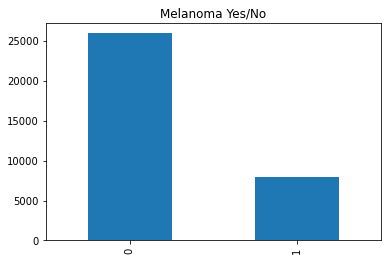

In [16]:
# check for class imbalance
df3['IS MEALANOMA ?'].value_counts().plot(kind='bar', title='Melanoma Yes/No')

In [17]:
df3.to_csv (r'deep_learning_df.csv', index = None, header=True) 

<p> Step 1 </p>

In [3]:
df4 = pd.read_csv('deep_learning_df.csv', delimiter = ',')
df4 = df4.sample(frac=1).reset_index(drop=True)
df4.head()

,GENE_NAME,AGE,TUMOUR_ORIGIN,TIER,PROTEIN_PRIMARY_STRUCTURE,IS MEALANOMA ?
0,1,0.0,1,1,MAALSGGGGGGAEPGQALFNGDMEPEAGAGAGAAASSAADPAIPEE...,1
1,1,0.0,0,1,MAALSGGGGGGAEPGQALFNGDMEPEAGAGAGAAASSAADPAIPEE...,0
2,0,0.0,1,1,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,0
3,3,45.0,0,1,MSEFLLALLTLSGLLPIARVLTVGADRDQQLCDPGEFLCHDHVTCV...,0
4,2,0.0,2,2,MLKPSGLPGSSSPTRSLMTGSRSTKATPEMDSGLTGATLSPKTSTG...,1


In [4]:
# A C D E F G H I K L M N P Q R S T V W Y

In [11]:
amino_acid_index = {'A' : 0, 'C' : 1, 'D' : 2, 'E' : 3, 'F' : 4, 'G' : 5, 'H' : 6, 'I' : 7, 'K' : 8, 'L' : 9, 'M' : 10, 'N' : 11, 'P' : 12, 'Q' : 13, 'R' : 14, 'S' : 15, 'T' : 16, 'V' : 17, 'W' : 18, 'Y' : 19}
MATRIX_SIZE = 20
MAX = 0
def pps_as_matrix(pps):
    M = []
    for i in range(MATRIX_SIZE):
        l = []
        for j in range(MATRIX_SIZE):
            l.append(0)
        M.append(l)
            
    size = len(pps)
    for i in range(size-1):
        M[amino_acid_index[pps[i]]][amino_acid_index[pps[i+1]]] += 1
        global MAX
        if MAX < M[amino_acid_index[pps[i]]][amino_acid_index[pps[i+1]]]:
            MAX = M[amino_acid_index[pps[i]]][amino_acid_index[pps[i+1]]]
    
    return np.array(M).reshape(MATRIX_SIZE, MATRIX_SIZE, 1)
        

In [12]:
df_list1 = []
df_list2 = []
y_list = []

for index, row in df4.iterrows():
    # try :
    df_list1.append(pps_as_matrix(row['PROTEIN_PRIMARY_STRUCTURE']))
    df_list2.append({'GENE_NAME' : row['GENE_NAME'],  'AGE' : row['AGE'], 'TUMOUR_ORIGIN' : row['TUMOUR_ORIGIN'] , 'TIER' : row['TIER']})
    y_list.append(row['IS MEALANOMA ?'])
#     except:
#         continue

X_1 = np.array(df_list1)
X_2 = pd.DataFrame(df_list2)
y = np.array(y_list)

In [13]:
X_1.shape

(33906, 20, 20, 1)

In [14]:
X_2.shape

(33906, 4)

In [15]:
y.shape

(33906,)

In [16]:
X_2.isnull().any()

GENE_NAME        False
AGE              False
TUMOUR_ORIGIN    False
TIER             False
dtype: bool

In [17]:
train_size = (int) ((y.shape[0] / 100) * 80)
test_size = y.shape[0] - train_size
train_size, test_size

(27124, 6782)

In [18]:
X1_train = X_1[:train_size]
X2_train = X_2[:train_size]

X1_test = X_1[train_size:]
X2_test = X_2[train_size:]

y_train = y[:train_size]
y_test = y[train_size:]

In [19]:
X1_train.shape, X2_train.shape, X1_test.shape, X2_test.shape, y_train.shape, y_test.shape

((27124, 20, 20, 1),
 (27124, 4),
 (6782, 20, 20, 1),
 (6782, 4),
 (27124,),
 (6782,))

### DP Model

In [21]:
# determine the shape of the input 
in_shape = X1_train.shape[1:]
in_shape

(20, 20, 1)

In [22]:
# determine the number of classes
n_classes = len(np.unique(y_train))
print(in_shape, n_classes)

(20, 20, 1) 2


In [27]:
MAX

646

In [28]:
# normalize 
X1_train = X1_train.astype('float32') / MAX
X1_test = X1_test.astype('float32') / MAX

In [29]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from numpy import argmax
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization

In [44]:
# define model
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', input_shape=in_shape))
model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform'))
# model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='relu', use_bias=True, kernel_initializer=tf.keras.initializers.HeNormal(seed=1005), kernel_regularizer=tf.keras.regularizers.L1(0.01)))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(50, activation='relu', use_bias=True, kernel_initializer=tf.keras.initializers.HeNormal(seed=3005), kernel_regularizer=tf.keras.regularizers.L1(0.01)))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(Dense(n_classes, activation='softmax'))

In [45]:
# define loss and optimizer

# define the model
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.05)

model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [46]:
# fit the model
history =  model.fit(X1_train, y_train, epochs=25, batch_size=256, validation_split=0.3)

Epoch 1/25
75/75 [==============================] - 5s 64ms/step - loss: 83.8882 - accuracy: 0.6540 - val_loss: 58.4949 - val_accuracy: 0.7665
Epoch 2/25
75/75 [==============================] - 5s 64ms/step - loss: 41.4985 - accuracy: 0.7296 - val_loss: 26.8201 - val_accuracy: 0.7665
Epoch 3/25
75/75 [==============================] - 5s 63ms/step - loss: 18.1771 - accuracy: 0.7428 - val_loss: 11.3029 - val_accuracy: 0.7665
Epoch 4/25
75/75 [==============================] - 5s 62ms/step - loss: 7.9853 - accuracy: 0.7440 - val_loss: 5.7304 - val_accuracy: 0.7665
Epoch 5/25
75/75 [==============================] - 5s 62ms/step - loss: 5.2024 - accuracy: 0.7497 - val_loss: 4.9452 - val_accuracy: 0.7665
Epoch 6/25
75/75 [==============================] - 5s 63ms/step - loss: 4.7945 - accuracy: 0.7486 - val_loss: 4.6161 - val_accuracy: 0.7665
Epoch 7/25
75/75 [==============================] - 5s 64ms/step - loss: 4.4757 - accuracy: 0.7504 - val_loss: 4.3013 - val_accuracy: 0.7665
Epoch 8

In [47]:
# evaluate the model
loss, acc = model.evaluate(X1_test, y_test, verbose=0)
print('Accuracy: %.3f' % acc)

Accuracy: 0.763


In [34]:
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report,mean_squared_error

In [42]:
pred = model.predict(X1_test)

In [43]:
for p in pred:
    l = argmax(p)
    if l == 1:
        print(l)